# Visualize Experiment Results

In [1]:
import os
import re

import pandas as pd
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from data_imputation_paper.experiment import read_experiment, read_csv_files

# plotting settings
sns.set(style="whitegrid")
sns.set_context('paper', font_scale=1.5)
mpl.rcParams['lines.linewidth'] = '2'

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Import the data

In [2]:
EXPERIMENT_PATH = Path("../data/experiments/cluster/fully_observed/")

In [3]:
read_experiment(EXPERIMENT_PATH).head()

,experiment,imputer,task,missing_type,missing_fraction,strategy,file_or_dir,detail_file,path
0,fully_observed,AutoKerasImputer,32,MCAR,0.01,single_all,impute_performance_std_input4.csv,,../data/experiments/cluster/fully_observed/Aut...
1,fully_observed,AutoKerasImputer,32,MCAR,0.01,single_all,downstream_performance_std_input4.csv,,../data/experiments/cluster/fully_observed/Aut...
2,fully_observed,AutoKerasImputer,32,MCAR,0.01,single_all,impute_performance_mean_input4.csv,,../data/experiments/cluster/fully_observed/Aut...
3,fully_observed,AutoKerasImputer,32,MCAR,0.01,single_all,downstream_performance_mean_input4.csv,,../data/experiments/cluster/fully_observed/Aut...
4,fully_observed,AutoKerasImputer,32,MCAR,0.01,single_all,input4,impute_performance_rep_2.csv,../data/experiments/cluster/fully_observed/Aut...


In [4]:
results = read_csv_files(read_experiment(EXPERIMENT_PATH))
results.drop("experiment", axis=1, inplace=True)
results.head()

,imputer,task,missing_type,missing_fraction,strategy,column,result_type,metric,train,test,baseline,corrupted,imputed
0,AutoKerasImputer,32,MCAR,0.01,single_all,input4,impute_performance,MAE,7.656001,0.188622,NaN,NaN,NaN
1,AutoKerasImputer,32,MCAR,0.01,single_all,input4,impute_performance,MSE,83.729988,0.035578,NaN,NaN,NaN
2,AutoKerasImputer,32,MCAR,0.01,single_all,input4,impute_performance,RMSE,9.150409,0.188622,NaN,NaN,NaN
3,AutoKerasImputer,32,MCAR,0.01,single_all,input4,impute_performance,MAE,4.332372,1.492393,NaN,NaN,NaN
4,AutoKerasImputer,32,MCAR,0.01,single_all,input4,impute_performance,MSE,26.302351,2.227238,NaN,NaN,NaN


## Data wrangling

1. gruppieren nach allen experimental conditions und dann nur ueber alle repetitions schauen, was die ranks der einzelnen imputation methoden warn
2. diese ranks aggregieren

In [5]:
EXPERIMENTAL_CONDITIONS = ["task", "missing_type", "missing_fraction", "strategy", "column", "result_type", "metric"]

ranked_data = results.groupby(EXPERIMENTAL_CONDITIONS).rank(ascending=False)
ranked_data = results.join(ranked_data, rsuffix="_rank")
ranked_data

,imputer,task,missing_type,missing_fraction,strategy,column,result_type,metric,train,test,baseline,corrupted,imputed,train_rank,test_rank,baseline_rank,corrupted_rank,imputed_rank
0,AutoKerasImputer,32,MCAR,0.01,single_all,input4,impute_performance,MAE,7.656001,0.188622,NaN,NaN,NaN,10.0,22.0,NaN,NaN,NaN
1,AutoKerasImputer,32,MCAR,0.01,single_all,input4,impute_performance,MSE,83.729988,0.035578,NaN,NaN,NaN,10.0,22.0,NaN,NaN,NaN
2,AutoKerasImputer,32,MCAR,0.01,single_all,input4,impute_performance,RMSE,9.150409,0.188622,NaN,NaN,NaN,10.0,22.0,NaN,NaN,NaN
3,AutoKerasImputer,32,MCAR,0.01,single_all,input4,impute_performance,MAE,4.332372,1.492393,NaN,NaN,NaN,13.0,19.0,NaN,NaN,NaN
4,AutoKerasImputer,32,MCAR,0.01,single_all,input4,impute_performance,MSE,26.302351,2.227238,NaN,NaN,NaN,13.0,19.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101605,KNNImputer,1220,MNAR,0.10,single_all,advertiser_id,downstream_performance,F1_macro,NaN,NaN,0.476541,0.476053,0.476053,NaN,NaN,8.0,9.5,9.5
101606,KNNImputer,1220,MNAR,0.10,single_all,advertiser_id,downstream_performance,F1_weighted,NaN,NaN,0.761524,0.761520,0.761520,NaN,NaN,8.0,8.5,8.5
101607,KNNImputer,1220,MNAR,0.10,single_all,advertiser_id,downstream_performance,F1_micro,NaN,NaN,0.827034,0.827034,0.827034,NaN,NaN,8.0,10.0,9.5
101608,KNNImputer,1220,MNAR,0.10,single_all,advertiser_id,downstream_performance,F1_macro,NaN,NaN,0.476541,0.476541,0.476541,NaN,NaN,8.0,5.5,5.5


## Visualize Classification Downstream Performance

In [6]:
CLF_METRIC = "F1_macro"
RESULT_TYPE = "downstream_performance"

<AxesSubplot:title={'center':'Imputed Rank KDE'}, ylabel='Density'>

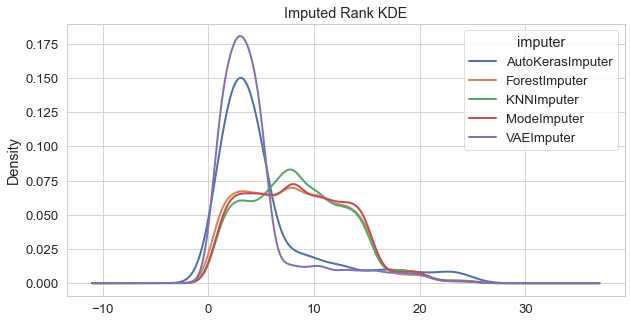

In [7]:
row_idx = (results["result_type"] == RESULT_TYPE) & (results["metric"] == CLF_METRIC)
plot_data = ranked_data.loc[row_idx, ["imputer", "imputed_rank"]]
plot_data = plot_data.pivot(columns="imputer", values="imputed_rank")

plot_data.plot(kind="kde", title="Imputed Rank KDE", figsize=(10,5))

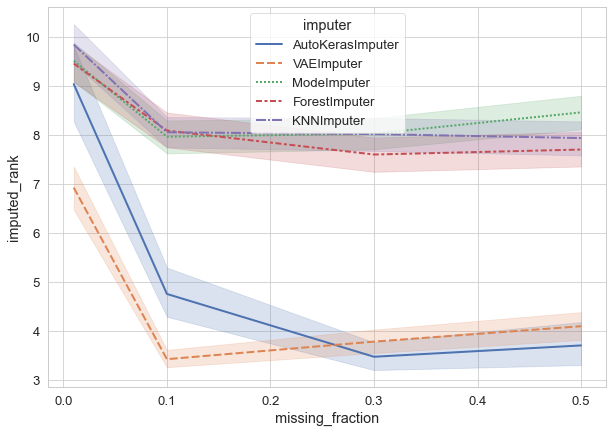

In [15]:
row_idx = (results["result_type"] == RESULT_TYPE) & (results["metric"] == CLF_METRIC)
plot_data = ranked_data.loc[row_idx]

plt.figure(figsize=(10,7))
ax = sns.lineplot(
    data=plot_data, 
    x="missing_fraction", 
    y="imputed_rank", 
    hue="imputer", 
    style="imputer"
)

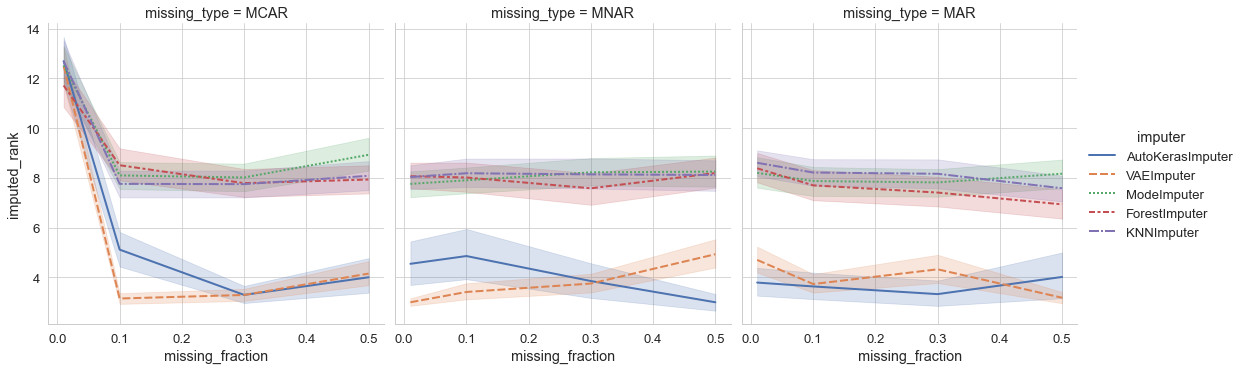

In [9]:
row_idx = (results["result_type"] == RESULT_TYPE) & (results["metric"] == CLF_METRIC)
plot_data = ranked_data[row_idx]

sns.relplot(
    data=plot_data, 
    x="missing_fraction", 
    y="imputed_rank", 
    hue="imputer", 
    style="imputer", 
    col="missing_type",
    kind="line"
)